# OSMnx tutorial

## Resources:
- [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.simplification.consolidate_intersections)
- [link 1](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
- [link 2](https://geoffboeing.com/2020/06/whats-new-with-osmnx/)
- [link 3](https://geoffboeing.com/tag/tutorial/)

## Invoke libraries

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import io
import geopandas as gpd
import earthpy as et
import json
from shapely.geometry import Point, LineString
from glob import glob

## Visualize maps

Plot with OSM & remove interstitial nodes
- [citation](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.simplify.simplify_graph)

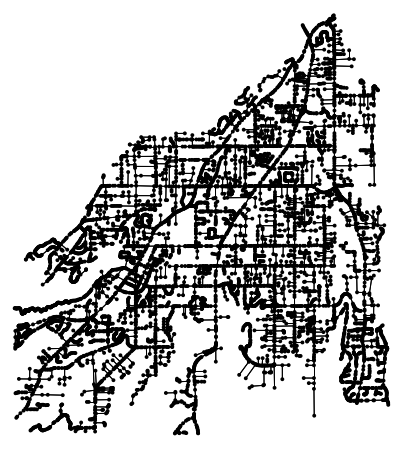

In [2]:
#cmap = plt.cm.get_cmap('viridis')

map = ox.graph_from_place('Paradise, California',
                          network_type='drive',
                          simplify=False) # Simplify a graph’s topology by removing interstitial nodes.

ox.plot_graph(map,
             bgcolor='#FFFFFF',
             edge_color='#000000',
             node_color='#000000');

In [4]:
# # show the simplified network with edges colored by length
# ec = ox.plot.get_edge_colors_by_attr(map_cons_speed, attr='length', cmap='plasma_r')
# fig, ax = ox.plot_graph(map, node_color='w', node_edgecolor='w', node_size=1,
#                         edge_color=ec, edge_linewidth=3,bgcolor='#FFFFFF')

Plot with matplotlib

In [5]:
#fig, ax = ox.plot_graph(map)
#plt.tight_layout()

### Consolidate intersections to compensate for overcounting 
- [citation](https://geoffboeing.com/2020/06/whats-new-with-osmnx/)

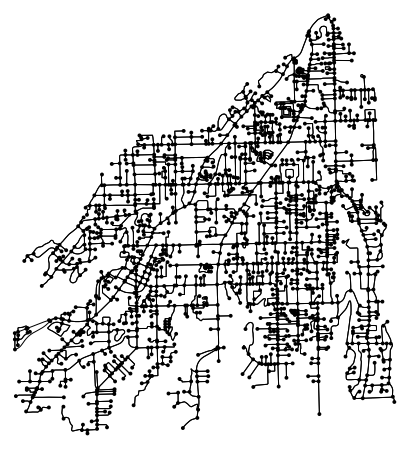

In [68]:
mapCons = ox.project_graph(ox.graph_from_place('Paradise, California', network_type='drive'))
map_cons = ox.consolidate_intersections(mapCons,
                                        tolerance=10,
                                        rebuild_graph=True,
                                        dead_ends=True)
ox.plot_graph(map_cons,
             bgcolor='#FFFFFF',
             edge_color='#000000',
             node_color='#000000');

## Basic statistics

In [65]:
# map = ox.graph_from_place('Pittsburg, Pennsylvania', network_type='drive')
basic_stats = ox.basic_stats(map_cons)
basic_stats
# basic_stats['streets_per_node_avg']

{'n': 874,
 'm': 2718,
 'k_avg': 6.219679633867277,
 'intersection_count': 679,
 'streets_per_node_avg': 2.734553775743707,
 'streets_per_node_counts': {0: 0, 1: 93, 2: 8, 3: 406, 4: 262, 5: 3},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.10640732265446225,
  2: 0.009153318077803204,
  3: 0.4645308924485126,
  4: 0.2997711670480549,
  5: 0.003432494279176201},
 'edge_length_total': 277515.01771127695,
 'edge_length_avg': 102.10265552291278,
 'street_length_total': 143334.52520026366,
 'street_length_avg': 101.36812248957825,
 'street_segments_count': 1414,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.4048734323419017e-05,
 'self_loop_proportion': 0.004782928623988227,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

Extended statistics

In [7]:
extended_stats = ox.extended_stats(map_cons, connectivity=True)

In [8]:
extended_stats['edge_connectivity']

1

### Extract edge/street speeds

- [citation](https://networkx.org/documentation/latest/auto_examples/geospatial/plot_osmnx.html)

In [9]:
# impute edge (driving) speeds and calculate edge traversal times
map_cons_speed = ox.add_edge_speeds(map_cons)
map_cons_speed = ox.add_edge_travel_times(map_cons_speed)

### Extract nodes (intersections) and edges (streets)

In [10]:
# you can convert MultiDiGraph to/from geopandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(map_cons_speed)
map_cons_speed = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=map_cons_speed.graph)
gdf_nodes.shape, gdf_edges.shape
# nodes, edges = ox.graph_to_gdfs(map_cons)
# nodes.shape, edges.shape

((1793, 8), (3990, 13))

- **Count types of roads**

In [11]:
print(gdf_edges['highway'].value_counts())

residential                3271
tertiary                    444
secondary                   230
unclassified                 28
trunk                        15
[tertiary, residential]       2
Name: highway, dtype: int64


Edges, from node u to v (see this [link](https://osmnx.readthedocs.io/en/stable/) for more detail)

In [12]:
gdf_edges

osmid              name      highway  oneway   length  \
u     v   key                                                              
0     2   0     10290687         York Road  residential   False   64.271   
1     5   0     10297459      Diduca Court  residential   False  110.959   
      10  0     10295615      Wayland Road  residential   False  588.100   
      2   0     10295615      Wayland Road  residential   False  112.158   
2     0   0     10290687         York Road  residential   False   64.271   
...                  ...               ...          ...     ...      ...   
709-1 690 0     10289997               NaN  residential   False   75.184   
728-0 740 0     10296213  Locust Vale Road  residential   False  160.632   
728-1 727 0    629318940     Nunneley Road     tertiary   False   56.780   
      702 0    629318940     Nunneley Road     tertiary   False  157.246   
      656 0    899951749  Locust Vale Road  residential   False  155.879   

                                                        geometry  u_original  \
u     v   key                                                                  
0     2   0    LINESTRING (616678.276 4398207.926, 616677.302...    86435684   
1     5   0    LINESTRING (616566.853 4398274.510, 616587.833...    86556378   
      10  0    LINESTRING (616566.853 4398274.510, 616558.936...    86556378   
      2   0    LINESTRING (616566.853 4398274.510, 616574.769...    86556378   
2     0   0    LINESTRING (616677.302 4398272.079, 616678.276...    86435682   
...                                                          ...         ...   
709-1 690 0    LINESTRING (619505.337 4401653.874, 619510.079...    86416087   
728-0 740 0    LINESTRING (621070.600 4401621.459, 621072.697...  8361405942   
728-1 727 0    LINESTRING (621074.694 4401621.557, 621070.600...  8361405943   
      702 0    LINESTRING (621074.694 4401621.557, 621113.000...  8361405943   
      656 0    LINESTRING (621074.694 4401621.557, 621075.926...  8361405943   

               v_original  speed_kph  travel_time maxspeed  ref lanes  
u     v   key                                                          
0     2   0      86435682       44.3          5.2      NaN  NaN   NaN  
1     5   0      86605677       44.3          9.0      NaN  NaN   NaN  
      10  0      86556473       44.3         47.8      NaN  NaN   NaN  
      2   0      86435682       44.3          9.1      NaN  NaN   NaN  
2     0   0      86435684       44.3          5.2      NaN  NaN   NaN  
...                   ...        ...          ...      ...  ...   ...  
709-1 690 0      86416075       44.3          6.1      NaN  NaN   NaN  
728-0 740 0      86575431       44.3         13.1      NaN  NaN   NaN  
728-1 727 0    8365552777       53.9          3.8      NaN  NaN     2  
      702 0    8361438308       53.9         10.5      NaN  NaN     2  
      656 0      86575426       44.3         12.7      NaN  NaN   NaN  

[3990 rows x 13 columns]

> [note](https://osmnx.readthedocs.io/en/stable/) that `u` and `v` are nodes linked by a given edge such that a one-way street/edge will connect node `u` and `v` while a "bidirectional street will be represented with two reciprocal directed edges (with identical geometries): one from node u to node v and another from v to u, to represent both possible directions of flow" 

In [13]:
gdf_nodes

osmid_original             y              x  street_count         lon  \
osmid                                                                          
0            86435684  4.398208e+06  616678.276142           1.0 -121.638553   
1            86556378  4.398275e+06  616566.852713           3.0 -121.639841   
2            86435682  4.398272e+06  616677.301700           4.0 -121.638553   
3            86471917  4.398316e+06  618587.235226           3.0 -121.616265   
4            86477502  4.398330e+06  617069.208938           1.0 -121.633971   
...               ...           ...            ...           ...         ...   
1624-1       86413669  4.404735e+06  620956.616008           1.0 -121.587445   
709-0        86479783  4.401674e+06  619504.258563           1.0 -121.604958   
709-1        86416087  4.401654e+06  619505.337259           1.0 -121.604949   
728-0      8361405942  4.401621e+06  621070.599949           1.0 -121.586688   
728-1      8361405943  4.401622e+06  621074.694338           3.0 -121.586640   

              lat highway                        geometry  
osmid                                                      
0       39.725777     NaN  POINT (616678.276 4398207.926)  
1       39.726392     NaN  POINT (616566.853 4398274.510)  
2       39.726355     NaN  POINT (616677.302 4398272.079)  
3       39.726484     NaN  POINT (618587.235 4398315.604)  
4       39.726821     NaN  POINT (617069.209 4398329.775)  
...           ...     ...                             ...  
1624-1  39.783975     NaN  POINT (620956.616 4404735.204)  
709-0   39.756603     NaN  POINT (619504.259 4401673.619)  
709-1   39.756425     NaN  POINT (619505.337 4401653.874)  
728-0   39.755912     NaN  POINT (621070.600 4401621.459)  
728-1   39.755912     NaN  POINT (621074.694 4401621.557)  

[1793 rows x 8 columns]

> [note](https://stackoverflow.com/questions/46238813/osmnx-get-coordinates-of-nodes-using-osm-id) on `x` and `y` 

- Check if any edges are missing speed limits

In [14]:
gdf_edges["speed_kph"].isna().sum()

0

- Remove edges with speed limit below 35 mph or 56.327 kph

In [15]:
edges_35mph = gdf_edges[gdf_edges["speed_kph"] > 56]
edges_35mph

osmid                     name       highway  oneway  \
u    v    key                                                             
3    11   0     10292328  Round Valley Ranch Road  unclassified   False   
11   3    0     10292328  Round Valley Ranch Road  unclassified   False   
     17   0    882480954               Clark Road     secondary   False   
15   59   0    538864405                Neal Road      tertiary   False   
16   24   0    900830447           Rivendell Lane  unclassified   False   
...                  ...                      ...           ...     ...   
1750 1603 0    868617247               Clark Road     secondary   False   
1767 1097 0     30058272               Clark Road     secondary   False   
     1000 0     30058272               Clark Road     secondary   False   
1769 1092 0     10293494               Pentz Road      tertiary   False   
     1004 0     10293494               Pentz Road      tertiary   False   

                length                                           geometry  \
u    v    key                                                               
3    11   0    363.465  LINESTRING (618587.235 4398315.604, 618599.178...   
11   3    0    363.465  LINESTRING (618876.693 4398518.289, 618844.073...   
     17   0    166.719  LINESTRING (618876.693 4398518.289, 618875.755...   
15   59   0    210.253  LINESTRING (615450.354 4398647.757, 615480.358...   
16   24   0     99.126  LINESTRING (615744.441 4398680.581, 615740.872...   
...                ...                                                ...   
1750 1603 0    108.014  LINESTRING (621060.017 4405059.572, 621054.293...   
1767 1097 0    107.160  LINESTRING (619664.456 4402604.454, 619668.972...   
     1000 0     89.315  LINESTRING (619664.456 4402604.454, 619650.863...   
1769 1092 0     61.038  LINESTRING (622082.354 4402632.451, 622080.451...   
     1004 0    139.520  LINESTRING (622082.354 4402632.451, 622084.716...   

               u_original  v_original  speed_kph  travel_time maxspeed  \
u    v    key                                                            
3    11   0      86471917    86430069       56.6         23.1      NaN   
11   3    0      86430069    86471917       56.6         23.1      NaN   
     17   0      86430069  5375953903       88.5          6.8   55 mph   
15   59   0      86502136    86422349       56.3         13.4   35 mph   
16   24   0      86581977  8368020519       56.6          6.3      NaN   
...                   ...         ...        ...          ...      ...   
1750 1603 0      86430440    86406961       56.3          6.9   35 mph   
1767 1097 0      86430277    86430291       56.3          6.9   35 mph   
     1000 0      86430277    86430271       56.3          5.7   35 mph   
1769 1092 0      86466048    86420503       56.3          3.9   35 mph   
     1004 0      86466048    86500449       56.3          8.9   35 mph   

                  ref lanes  
u    v    key                
3    11   0       NaN   NaN  
11   3    0       NaN   NaN  
     17   0    CA 191   NaN  
15   59   0       NaN     2  
16   24   0       NaN   NaN  
...               ...   ...  
1750 1603 0       NaN   NaN  
1767 1097 0       NaN   NaN  
     1000 0       NaN   NaN  
1769 1092 0       NaN   NaN  
     1004 0       NaN   NaN  

[467 rows x 13 columns]

Visualize roads by speed limit

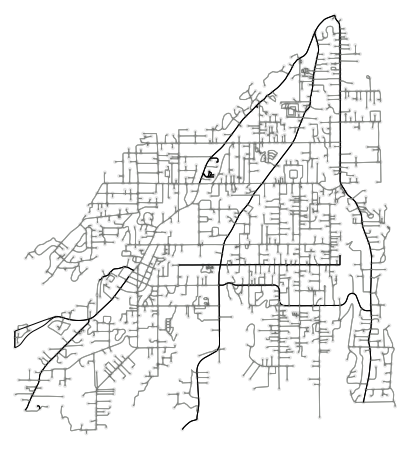

In [16]:
G = ox.graph_from_place('Paradise, California', network_type='drive')
G = ox.add_edge_speeds(G)
ec = ['#929591' if d < 50 else 'k' for u, v, d in G.edges(data='speed_kph')]
fig, ax = ox.plot_graph(G, node_alpha=0.1, edge_color=ec,
                                     bgcolor='#FFFFFF',
                        node_color='#000000')

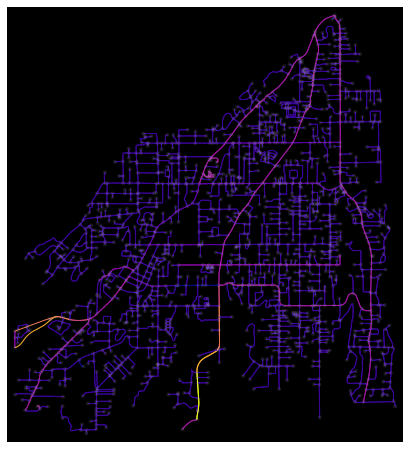

In [17]:
G = ox.graph_from_place('Paradise, California', network_type='drive')
G = ox.add_edge_speeds(G)
ec = ox.plot.get_edge_colors_by_attr(G, 'speed_kph', cmap='plasma')
fig, ax = ox.plot_graph(G, node_alpha=0.1, edge_color=ec, bgcolor='k')

- [citation](https://stackoverflow.com/questions/65970051/plot-edges-conditional-on-speed-limit-in-pythons-osmnx)

- https://github.com/gboeing/osmnx-examples/blob/master/notebooks/01-overview-osmnx.ipynb

- Convert `x`, `y` coordinates to lat and long

In [18]:
edges_35mph = ox.project_gdf(edges_35mph, to_latlong=True)
edges_35mph

osmid                     name       highway  oneway  \
u    v    key                                                             
3    11   0     10292328  Round Valley Ranch Road  unclassified   False   
11   3    0     10292328  Round Valley Ranch Road  unclassified   False   
     17   0    882480954               Clark Road     secondary   False   
15   59   0    538864405                Neal Road      tertiary   False   
16   24   0    900830447           Rivendell Lane  unclassified   False   
...                  ...                      ...           ...     ...   
1750 1603 0    868617247               Clark Road     secondary   False   
1767 1097 0     30058272               Clark Road     secondary   False   
     1000 0     30058272               Clark Road     secondary   False   
1769 1092 0     10293494               Pentz Road      tertiary   False   
     1004 0     10293494               Pentz Road      tertiary   False   

                length                                           geometry  \
u    v    key                                                               
3    11   0    363.465  LINESTRING (-121.61627 39.72648, -121.61612 39...   
11   3    0    363.465  LINESTRING (-121.61285 39.72827, -121.61323 39...   
     17   0    166.719  LINESTRING (-121.61285 39.72827, -121.61286 39...   
15   59   0    210.253  LINESTRING (-121.65280 39.72991, -121.65244 39...   
16   24   0     99.126  LINESTRING (-121.64936 39.73016, -121.64940 39...   
...                ...                                                ...   
1750 1603 0    108.014  LINESTRING (-121.58618 39.78688, -121.58625 39...   
1767 1097 0    107.160  LINESTRING (-121.60292 39.76496, -121.60286 39...   
     1000 0     89.315  LINESTRING (-121.60292 39.76496, -121.60308 39...   
1769 1092 0     61.038  LINESTRING (-121.57469 39.76487, -121.57471 39...   
     1004 0    139.520  LINESTRING (-121.57469 39.76487, -121.57467 39...   

               u_original  v_original  speed_kph  travel_time maxspeed  \
u    v    key                                                            
3    11   0      86471917    86430069       56.6         23.1      NaN   
11   3    0      86430069    86471917       56.6         23.1      NaN   
     17   0      86430069  5375953903       88.5          6.8   55 mph   
15   59   0      86502136    86422349       56.3         13.4   35 mph   
16   24   0      86581977  8368020519       56.6          6.3      NaN   
...                   ...         ...        ...          ...      ...   
1750 1603 0      86430440    86406961       56.3          6.9   35 mph   
1767 1097 0      86430277    86430291       56.3          6.9   35 mph   
     1000 0      86430277    86430271       56.3          5.7   35 mph   
1769 1092 0      86466048    86420503       56.3          3.9   35 mph   
     1004 0      86466048    86500449       56.3          8.9   35 mph   

                  ref lanes  
u    v    key                
3    11   0       NaN   NaN  
11   3    0       NaN   NaN  
     17   0    CA 191   NaN  
15   59   0       NaN     2  
16   24   0       NaN   NaN  
...               ...   ...  
1750 1603 0       NaN   NaN  
1767 1097 0       NaN   NaN  
     1000 0       NaN   NaN  
1769 1092 0       NaN   NaN  
     1004 0       NaN   NaN  

[467 rows x 13 columns]

### Number of streets per intersection

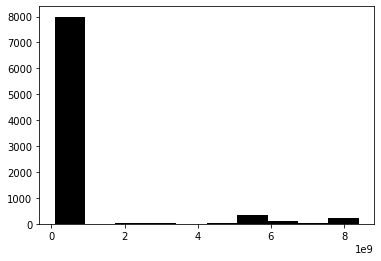

In [19]:
plt.hist(ox.utils_graph.count_streets_per_node(map),
         color='k');

### Number of lanes per street

**percent of edges and nodes with NaNs**

In [20]:
print("% of edges without lanes/street data:", gdf_edges["lanes"].isna().sum()/ gdf_edges.shape[0])
print("% of nodes without lanes/street data:", gdf_nodes["street_count"].isna().sum()/ gdf_nodes.shape[0])

% of edges without lanes/street data: 0.962907268170426
% of nodes without lanes/street data: 0.027328499721137756


Subset columns of interest

In [21]:
gdf_edges = edges_35mph[['name','highway', 'oneway', 'length','lanes','speed_kph', 'maxspeed', 'travel_time','geometry']]

**Edges/streets with non-NaN values for the number of lanes**

In [22]:
EdgesWithLaneData = gdf_edges[gdf_edges['lanes'].notnull()]
EdgesWithLaneData.head()
# Export
#EdgesWithLaneData.to_csv (r'./OSMData/Edges35WithLaneData.csv', index = False, header=True)

**Edges/streets with NaN values for the number of lanes**

In [23]:
EdgesWithoutLaneData = gdf_edges[gdf_edges['lanes'].isnull()]
EdgesWithoutLaneData.head()
# Export
#EdgesWithoutLaneData.to_csv (r'./OSMData/Edges35WithoutLaneData.csv', index = False, header=True)

**Nodes/instersectons with non-NaN values for the number of streets**

In [24]:
NodesWithStreetData = gdf_nodes[gdf_nodes['street_count'].notnull()]
NodesWithStreetData.head()
# Export
# NodesWithStreetData.to_csv (r'./OSMData/NodesWithStreetData.csv', index = False, header=True)

osmid_original             y              x  street_count         lon  \
osmid                                                                         
0           86435684  4.398208e+06  616678.276142           1.0 -121.638553   
1           86556378  4.398275e+06  616566.852713           3.0 -121.639841   
2           86435682  4.398272e+06  616677.301700           4.0 -121.638553   
3           86471917  4.398316e+06  618587.235226           3.0 -121.616265   
4           86477502  4.398330e+06  617069.208938           1.0 -121.633971   

             lat highway                        geometry  
osmid                                                     
0      39.725777     NaN  POINT (616678.276 4398207.926)  
1      39.726392     NaN  POINT (616566.853 4398274.510)  
2      39.726355     NaN  POINT (616677.302 4398272.079)  
3      39.726484     NaN  POINT (618587.235 4398315.604)  
4      39.726821     NaN  POINT (617069.209 4398329.775)

**Nodes/instersectons with non-NaN values for the number of streets**

In [23]:
NodesWithoutStreetData = gdf_nodes[gdf_nodes['street_count'].isnull()]
NodesWithoutStreetData.head()
# Export
# NodesWithoutStreetData.to_csv (r'./OSMData/NodesWithoutStreetData.csv', index = False, header=True)

osmid_original             y              x  \
osmid                                                                    
54                 [86519921, 4289644960]  4.399024e+06  618491.812609   
95                 [8342728357, 86520701]  4.399363e+06  617126.807945   
149    [5383263025, 86458473, 5383263024]  4.399596e+06  618077.657212   
182                [8184820527, 86502213]  4.399870e+06  616161.186170   
223                  [86461513, 86475432]  4.399739e+06  618177.324169   

       street_count  lon  lat highway                        geometry  
osmid                                                                  
54              NaN  NaN  NaN     NaN  POINT (618491.813 4399023.661)  
95              NaN  NaN  NaN     NaN  POINT (617126.808 4399363.009)  
149             NaN  NaN  NaN     NaN  POINT (618077.657 4399596.113)  
182             NaN  NaN  NaN     NaN  POINT (616161.186 4399869.762)  
223             NaN  NaN  NaN     NaN  POINT (618177.324 4399739.007)

**Visualize street direction**

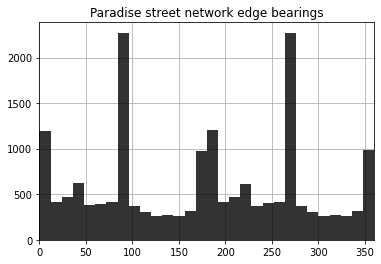

In [24]:
# calculate edge bearings and visualize their frequency
G = ox.add_edge_bearings(map)
bearings = pd.Series([data['bearing'] for u, v, k, data in G.edges(keys=True, data=True)])
ax = bearings.hist(bins=30, zorder=2, alpha=0.8, color='k')
ax.set_xlim(0, 360)
ax.set_title('Paradise street network edge bearings')
plt.show()

**Polar chart**

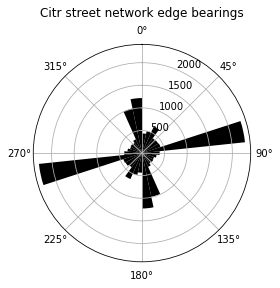

In [25]:
# polar plot
n = 30
count, division = np.histogram(bearings, bins=[ang*360/n for ang in range(0,n+1)])
division = division[0:-1]
width =  2 * np.pi/n
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction('clockwise')
bars = ax.bar(division * np.pi/180 - width * 0.5 , count, width=width, bottom=20.0, color='k')
ax.set_title('Citr street network edge bearings', y=1.1)
plt.show()

### Export data as GeoJSON file

- [graph to shape, geo, and graph](https://networkx.org/documentation/latest/auto_examples/geospatial/plot_osmnx.html)
- [df to GeoJSON](https://geoffboeing.com/2015/10/exporting-python-data-geojson/)

In [74]:
# save graph to shapefile, geopackage, or graphml
ox.save_graph_shapefile(G, filepath="./graph_shapefile/")
ox.save_graph_geopackage(G, filepath="./graph.gpkg")
ox.save_graphml(G, filepath="./graph.graphml")

#### Grab shape files for cities powered by PG&E

import shapefiles

- Entire region

In [90]:
# import shapefile using geopandas
PGnE = pd.read_csv('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_est/Trials/PG&ECities/PGnECities.csv')

In [4]:
PGnE.head()

Name  Type   County Population2010  LandArea_SqMi   km2  \
0          Alameda  City  Alameda         73,812          10.61  27.5   
1           Albany  City  Alameda         18,539           1.79   4.6   
2      Amador City  City   Amador            185           0.31   0.8   
3  American Canyon  City     Napa         19,454           4.84  12.5   
4         Anderson  City   Shasta          9,932           6.37  16.5   

     Incorporated  Unknown  
0  April 19, 1854      3.0  
1       22-Sep-08      4.0  
2        2-Jun-15      8.0  
3        1-Jan-92      9.0  
4       16-Jan-56     11.0

Split data into cities and counties

In [5]:
counties = ["Alameda",
"Alpine",
"Amador",
"Butte",
"Calaveras",
"Colusa",
"Contra Costa",
"Del Norte",
"El Dorado",
"Fresno",
"Glenn",
"Humboldt",
"Imperial",
"Inyo",
"Kern",
"Kings",
"Lake",
"Lassen",
"Los Angeles",
"Madera",
"Marin",
"Mariposa",
"Mendocino",
"Merced",
"Modoc",
"Mono",
"Monterey",
"Napa",
"Nevada",
"Orange",
"Placer",
"Plumas",
"Riverside",
"Sacramento",
"San Benito",
"San Bernardino",
"San Diego",
"San Francisco",
"San Joaquin",
"San Luis Obispo",
"San Mateo",
"Santa Barbara",
"Santa Clara",
"Santa Cruz",
"Shasta",
"Sierra",
"Siskiyou",
"Solano",
"Sonoma",
"Stanislaus",
"Sutter",
"Tehama",
"Trinity",
"Tulare",
"Tuolumne",
"Ventura",
"Yolo",
"Yuba"]

subset rows that are potentially counties

In [6]:
PGnE[PGnE["Name"].isin(counties)]

Name  Type           County Population2010  LandArea_SqMi  \
0            Alameda  City          Alameda         73,812          10.61   
38            Colusa  City           Colusa          5,971           1.83   
67            Fresno  City           Fresno        494,665         111.96   
103           Madera  City           Madera         61,416          15.79   
111           Merced  City           Merced         78,958          23.32   
117         Monterey  City         Monterey         27,810           8.47   
122             Napa  City             Napa         76,915          17.84   
167       Sacramento  City       Sacramento        466,488          97.92   
174      San Joaquin  City           Fresno          4,001           1.15   
178  San Luis Obispo  City  San Luis Obispo         45,119          12.78   
179        San Mateo  City        San Mateo         97,207          12.13   
185       Santa Cruz  City       Santa Cruz         59,946          12.74   
196           Sonoma  City           Sonoma         10,648           2.74   
204           Tehama  City           Tehama            418           0.79   
300        El Dorado   NaN        El Dorado            NaN            NaN   
343            Glenn   NaN            Glenn            NaN            NaN   
437        Mendocino   NaN        Mendocino            NaN            NaN   
597           Shasta   NaN           Shasta            NaN            NaN   
645           Sutter   NaN           Sutter            NaN            NaN   
667             Yolo   NaN             Yolo            NaN            NaN   

       km2       Incorporated  Unknown  
0     27.5     April 19, 1854      3.0  
38     4.7      June 16, 1868     87.0  
67   290.0   October 12, 1885    151.0  
103   40.9          27-Mar-07    245.0  
111   60.4      April 1, 1889    259.0  
117   21.9      June 14, 1890    270.0  
122   46.2     March 23, 1872    280.0  
167  253.6  February 27, 1850    360.0  
174    3.0          14-Feb-20    374.0  
178   33.1  February 16, 1856    379.0  
179   31.4  September 4, 1894    382.0  
185   33.0     March 31, 1866    392.0  
196    7.1  September 3, 1883    414.0  
204    2.0           5-Jul-06    429.0  
300    NaN                NaN      NaN  
343    NaN                NaN      NaN  
437    NaN                NaN      NaN  
597    NaN                NaN      NaN  
645    NaN                NaN      NaN  
667    NaN                NaN      NaN

- El Dorado, Glenn, Sutter, and Yolo are not cites but counties.

Subset all rows with NaNs with "Type" columns

In [7]:
PGnE[PGnE['Type'].isna()]

Name Type   County Population2010  LandArea_SqMi  km2  \
229     San Lorenzo  NaN  Alameda            NaN            NaN  NaN   
230           Sunol  NaN  Alameda            NaN            NaN  NaN   
231   Castro Valley  NaN  Alameda            NaN            NaN  NaN   
232         Drytown  NaN   Amador            NaN            NaN  NaN   
233      Fiddletown  NaN   Amador            NaN            NaN  NaN   
..              ...  ...      ...            ...            ...  ...   
690       Mad River  NaN  Trinity            NaN            NaN  NaN   
691          Salyer  NaN  Trinity            NaN            NaN  NaN   
692  Trinity Center  NaN  Trinity            NaN            NaN  NaN   
693     Weaverville  NaN  Trinity            NaN            NaN  NaN   
694           Zenia  NaN  Trinity            NaN            NaN  NaN   

    Incorporated  Unknown  
229          NaN      NaN  
230          NaN      NaN  
231          NaN      NaN  
232          NaN      NaN  
233          NaN      NaN  
..           ...      ...  
690          NaN      NaN  
691          NaN      NaN  
692          NaN      NaN  
693          NaN      NaN  
694          NaN      NaN  

[466 rows x 8 columns]

Any duplicate rows

In [8]:
PGnE[PGnE.duplicated()]

Empty DataFrame
Columns: [Name, Type, County, Population2010, LandArea_SqMi, km2, Incorporated, Unknown]
Index: []

- Add ", California" to each city name

In [9]:
PGnE["Name"] = PGnE["Name"].astype(str) + ", California"

- sanity check

In [10]:
PGnE[["Name"]]

Name
0            Alameda, California
1             Albany, California
2        Amador City, California
3    American Canyon, California
4           Anderson, California
..                           ...
690        Mad River, California
691           Salyer, California
692   Trinity Center, California
693      Weaverville, California
694            Zenia, California

[695 rows x 1 columns]

In [4]:
os.getcwd()
os.chdir('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_est/Trials/PG&ECities/GeoJSONS')
os.getcwd()

'/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_est/Trials/PG&ECities/GeoJSONS'

- Create GeoPandas DataFrames

> - [citation](https://geoffboeing.com/2015/10/exporting-python-data-geojson/)

In [121]:
# def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
#     geojson = {'type':'FeatureCollection', 'features':[]}
#     for _, row in df.iterrows():
#         feature = {'type':'Feature',
#                    'properties':{},
#                    'geometry':{'type':'Point',
#                                'coordinates':[]}}
#         feature['geometry']['coordinates'] = [row[lon],row[lat]]
#         for prop in properties:
#             feature['properties'][prop] = row[prop]
#         geojson['features'].append(feature)
#     return geojson

- Convert to GeoJSON!

In [16]:
# Instantiate empty vector
gdfs = []

# For each city in the column of PG&E Names
for city in PGnE["Name"]:
    # Attempt to...
    try: 
        # Convert to geopandas dataframe
        gdfs = ox.geocode_to_gdf(city)
        # Convert geopandas dataframe to GeoJSON file
        gdfs.to_file(filename='./{}.geojson'.format(city), driver='GeoJSON')
#         GF = df_to_geojson(gdfs, gdfs.columns, lat="lat", lon="lon") 
#         GF.to_json()
#         # And save as        
#         output_filename = '{}'.format(city)
#         with open(output_filename, 'wb') as output_file:
#             output_file.write('var dataset = ')
#             json.dump(GJ, output_file, indent=2)
    # Otherwise        
    except ValueError:
        # Pass
        pass  

- From how many cities do we have geoJSON files?

In [26]:
# Instantiate counter
count = 0
# Set directory
d = '/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_est/Trials/PG&ECities/GeoJSONS'
# For the paths in the directory
for path in os.listdir(d):
    # If theres a file
    if os.path.isfile(os.path.join(d, path)):
        # Add 1
        count += 1
# Report
print("GeoJSON files for",count, "of",len(PGnE[["Name"]]), "cities serviced by PG&E" )

GeoJSON files for 436 of 695 cities serviced by PG&E


- Get list of all files in directory

In [17]:
cities = os.listdir()
print(cities[0:25])

['Sausalito, California.geojson', 'Red Bluff, California.geojson', 'Maxwell, California.geojson', 'Red Mountain, California.geojson', 'Weaverville, California.geojson', 'Folsom, California.geojson', 'Rodeo, California.geojson', 'Yountville, California.geojson', 'Lucerne, California.geojson', 'Sunnyvale, California.geojson', 'Yolo, California.geojson', 'Hidden Valley Lake, California.geojson', 'Fort Bragg, California.geojson', 'Bradley, California.geojson', 'Boulder Creek, California.geojson', 'Pleasanton, California.geojson', 'Sonoma, California.geojson', 'Auburn, California.geojson', 'Arvin, California.geojson', 'Avery, California.geojson', 'San Ramon, California.geojson', 'Mill Valley, California.geojson', 'Madera, California.geojson', 'Ragged Point, California.geojson', 'Sanger, California.geojson']


- remove .geojson from list of file names 

In [18]:
# empty list to populate with names
PGnEcities = []
# for each city, c , in list of cities, arr
for c in arr:
    # Append cities to list
    PGnEcities.append(c.split(".")[0])

NameError: name 'arr' is not defined

- Confirm that files are readable

(34.0, 42.0)

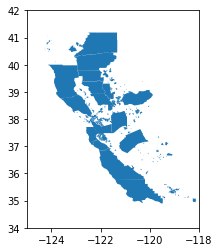

In [5]:
g = gpd.read_file('combined.geojson')
g['geometry'].plot();
plt.xlim([-125, -118])
plt.ylim([34,42])

In [13]:
g.display_name

0              Alameda County, California, United States
1      Alamo, Danville, Contra Costa County, Californ...
2      Albany, Alameda County, California, United States
3      Le California, Labège, Toulouse, Haute-Garonne...
4      Amador City, Amador County, California, 95601,...
                             ...                        
429    Woodland, Yolo County, California, 95695, Unit...
430    Woodside, San Mateo County, California, United...
431               Yolo County, California, United States
432    Yountville, Napa County, California, United St...
433    Yuba City, Sutter County, California, United S...
Name: display_name, Length: 434, dtype: object

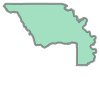

In [16]:
g['geometry'][431]

In [18]:
g

bbox_north  bbox_south   bbox_east   bbox_west   place_id  osm_type  \
0     37.906690   37.453950 -121.469090 -122.373843  258435952  relation   
1     37.903352   37.808680 -121.920455 -122.070776  296866799  relation   
2     37.898961   37.869572 -122.281701 -122.373843  258816770  relation   
3     43.542368   43.541195    1.509759    1.508298  250831112       way   
4     38.423712   38.413877 -120.817971 -120.830587  259373389  relation   
..          ...         ...         ...         ...        ...       ...   
429   38.709340   38.640812 -121.676677 -121.802757  258351598  relation   
430   37.460969   37.371866 -122.223281 -122.303389  259251752  relation   
431   38.925992   38.313340 -121.501170 -122.422928  257979274  relation   
432   38.413937   38.376890 -122.349661 -122.385600  259408476  relation   
433   39.175451   39.087183 -121.597591 -121.688874  258861488  relation   

        osm_id        lat         lon  \
0       396499  37.609029 -121.899142   
1       253974  37.856015 -121.993594   
2      2999142  37.886870 -122.297747   
3    831213232  43.541797    1.509000   
4     11049833  38.419355 -120.824103   
..         ...        ...         ...   
429     112607  38.678611 -121.773329   
430    9965434  37.429939 -122.253856   
431     396507  38.718454 -121.905900   
432   10095277  38.402201 -122.359506   
433    6428270  39.140448 -121.616911   

                                          display_name     class  \
0            Alameda County, California, United States  boundary   
1    Alamo, Danville, Contra Costa County, Californ...  boundary   
2    Albany, Alameda County, California, United States  boundary   
3    Le California, Labège, Toulouse, Haute-Garonne...   landuse   
4    Amador City, Amador County, California, 95601,...  boundary   
..                                                 ...       ...   
429  Woodland, Yolo County, California, 95695, Unit...  boundary   
430  Woodside, San Mateo County, California, United...  boundary   
431             Yolo County, California, United States  boundary   
432  Yountville, Napa County, California, United St...  boundary   
433  Yuba City, Sutter County, California, United S...  boundary   

               type  importance  \
0    administrative    0.776398   
1            census    0.647022   
2    administrative    0.679737   
3        commercial    0.300000   
4    administrative    0.714979   
..              ...         ...   
429  administrative    0.674167   
430  administrative    0.654889   
431  administrative    0.756582   
432  administrative    0.570000   
433  administrative    0.795550   

                                              geometry  
0    POLYGON ((-122.37384 37.88364, -122.37381 37.8...  
1    POLYGON ((-122.07078 37.82877, -122.06983 37.8...  
2    POLYGON ((-122.37384 37.88364, -122.37381 37.8...  
3    POLYGON ((1.50830 43.54172, 1.50861 43.54141, ...  
4    POLYGON ((-120.83059 38.41957, -120.83032 38.4...  
..                                                 ...  
429  MULTIPOLYGON (((-121.71911 38.64786, -121.7173...  
430  POLYGON ((-122.30339 37.42334, -122.30332 37.4...  
431  POLYGON ((-122.42293 38.90283, -122.42291 38.9...  
432  POLYGON ((-122.38560 38.38542, -122.38182 38.3...  
433  POLYGON ((-121.68887 39.14425, -121.68662 39.1...  

[434 rows x 14 columns]

In [22]:
g[g['display_name'].str.contains("County, California")]

bbox_north  bbox_south   bbox_east   bbox_west   place_id  osm_type  \
0     37.906690   37.453950 -121.469090 -122.373843  258435952  relation   
1     37.903352   37.808680 -121.920455 -122.070776  296866799  relation   
2     37.898961   37.869572 -122.281701 -122.373843  258816770  relation   
4     38.423712   38.413877 -120.817971 -120.830587  259373389  relation   
5     38.226037   38.221601 -122.226348 -122.227735   99530287       way   
..          ...         ...         ...         ...        ...       ...   
429   38.709340   38.640812 -121.676677 -121.802757  258351598  relation   
430   37.460969   37.371866 -122.223281 -122.303389  259251752  relation   
431   38.925992   38.313340 -121.501170 -122.422928  257979274  relation   
432   38.413937   38.376890 -122.349661 -122.385600  259408476  relation   
433   39.175451   39.087183 -121.597591 -121.688874  258861488  relation   

       osm_id        lat         lon  \
0      396499  37.609029 -121.899142   
1      253974  37.856015 -121.993594   
2     2999142  37.886870 -122.297747   
4    11049833  38.419355 -120.824103   
5    33073777  38.223457 -122.227043   
..        ...        ...         ...   
429    112607  38.678611 -121.773329   
430   9965434  37.429939 -122.253856   
431    396507  38.718454 -121.905900   
432  10095277  38.402201 -122.359506   
433   6428270  39.140448 -121.616911   

                                          display_name     class  \
0            Alameda County, California, United States  boundary   
1    Alamo, Danville, Contra Costa County, Californ...  boundary   
2    Albany, Alameda County, California, United States  boundary   
4    Amador City, Amador County, California, 95601,...  boundary   
5    American Canyon, Napa County, California, Unit...  boundary   
..                                                 ...       ...   
429  Woodland, Yolo County, California, 95695, Unit...  boundary   
430  Woodside, San Mateo County, California, United...  boundary   
431             Yolo County, California, United States  boundary   
432  Yountville, Napa County, California, United St...  boundary   
433  Yuba City, Sutter County, California, United S...  boundary   

               type  importance  \
0    administrative    0.776398   
1            census    0.647022   
2    administrative    0.679737   
4    administrative    0.714979   
5    administrative    0.749198   
..              ...         ...   
429  administrative    0.674167   
430  administrative    0.654889   
431  administrative    0.756582   
432  administrative    0.570000   
433  administrative    0.795550   

                                              geometry  
0    POLYGON ((-122.37384 37.88364, -122.37381 37.8...  
1    POLYGON ((-122.07078 37.82877, -122.06983 37.8...  
2    POLYGON ((-122.37384 37.88364, -122.37381 37.8...  
4    POLYGON ((-120.83059 38.41957, -120.83032 38.4...  
5    POLYGON ((-122.22773 38.22603, -122.22773 38.2...  
..                                                 ...  
429  MULTIPOLYGON (((-121.71911 38.64786, -121.7173...  
430  POLYGON ((-122.30339 37.42334, -122.30332 37.4...  
431  POLYGON ((-122.42293 38.90283, -122.42291 38.9...  
432  POLYGON ((-122.38560 38.38542, -122.38182 38.3...  
433  POLYGON ((-121.68887 39.14425, -121.68662 39.1...  

[427 rows x 14 columns]

In [41]:
g['display_name'][0].partition(',')

('Alameda County', ',', ' California, United States')

**Save street networks**

- get and set wd

In [60]:
os.getcwd()
os.chdir('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_est/Trials/PG&ECities/ShapeFiles')
os.getcwd()

'/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_est/Trials/PG&ECities/ShapeFiles'

- Subset cities with GeoJson files

In [80]:
PGnEshp = PGnE[PGnE['Name'].isin(PGnEcities)]

In [83]:
# Instantiate empty vector
sf = []

# For each city in the column of PG&E Names
for network in PGnEshp["Name"]:
    # Attempt to...
    try: 
        # Grab map
        G = ox.graph_from_place(network, network_type='drive')
        # if G is not connected
        if len(G) == 0:
            pass
        # otherwise
        else:
            # save graph as a shapefile
            ox.save_graph_shapefile(G, filepath='./{}.shp'.format(network))
    # Otherwise
    except ValueError:
        # Pass
        pass 

NetworkXPointlessConcept: Connectivity is undefined for the null graph.

### Append new feature properties to geojson files for each city serviced by PGE

Import file from Jun Hak

In [2]:
g = gpd.read_file('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_kelper/UnfoldedData/CensusDP.geojson')

In [3]:
g

NAME             NAMELSAD  Haz_zone  \
0         Cloverdale      Cloverdale city         2   
1             Cotati          Cotati city         2   
2            Benicia         Benicia city         0   
3              Dixon           Dixon city         1   
4          Rio Vista       Rio Vista city         0   
..               ...                  ...       ...   
935           Yettem           Yettem CDP         0   
936             Yolo             Yolo CDP         0   
937   Yosemite Lakes   Yosemite Lakes CDP         2   
938  Yosemite Valley  Yosemite Valley CDP         2   
939          Zayante          Zayante CDP         3   

                                              geometry  
0    MULTIPOLYGON (((-123.02144 38.81852, -123.0216...  
1    MULTIPOLYGON (((-122.69067 38.31982, -122.6957...  
2    MULTIPOLYGON (((-122.19518 38.06040, -122.1948...  
3    MULTIPOLYGON (((-121.80448 38.39105, -121.8038...  
4    MULTIPOLYGON (((-121.71389 38.19906, -121.7139...  
..                                                 ...  
935  MULTIPOLYGON (((-119.24955 36.48676, -119.2495...  
936  MULTIPOLYGON (((-121.81530 38.75000, -121.8138...  
937  MULTIPOLYGON (((-119.77305 37.23475, -119.7729...  
938  MULTIPOLYGON (((-119.57291 37.74729, -119.5728...  
939  MULTIPOLYGON (((-122.05079 37.05517, -122.0520...  

[940 rows x 4 columns]

Append ", California" to each city name

In [4]:
g["NAME"] = g["NAME"].astype(str) + ", California"

In [10]:
g

NAME             NAMELSAD  Haz_zone  \
0         Cloverdale, California      Cloverdale city         2   
1             Cotati, California          Cotati city         2   
2            Benicia, California         Benicia city         0   
3              Dixon, California           Dixon city         1   
4          Rio Vista, California       Rio Vista city         0   
..                           ...                  ...       ...   
935           Yettem, California           Yettem CDP         0   
936             Yolo, California             Yolo CDP         0   
937   Yosemite Lakes, California   Yosemite Lakes CDP         2   
938  Yosemite Valley, California  Yosemite Valley CDP         2   
939          Zayante, California          Zayante CDP         3   

                                              geometry  
0    MULTIPOLYGON (((-123.02144 38.81852, -123.0216...  
1    MULTIPOLYGON (((-122.69067 38.31982, -122.6957...  
2    MULTIPOLYGON (((-122.19518 38.06040, -122.1948...  
3    MULTIPOLYGON (((-121.80448 38.39105, -121.8038...  
4    MULTIPOLYGON (((-121.71389 38.19906, -121.7139...  
..                                                 ...  
935  MULTIPOLYGON (((-119.24955 36.48676, -119.2495...  
936  MULTIPOLYGON (((-121.81530 38.75000, -121.8138...  
937  MULTIPOLYGON (((-119.77305 37.23475, -119.7729...  
938  MULTIPOLYGON (((-119.57291 37.74729, -119.5728...  
939  MULTIPOLYGON (((-122.05079 37.05517, -122.0520...  

[940 rows x 4 columns]

#### append connectivity data

Test algorithm with subset of data

In [58]:
t = g.head(n=20)

In [11]:
# t=g[g['NAME'].str.contains("Cloverdale, California")]

In [44]:
# t

NAME         NAMELSAD  Haz_zone  \
0  Cloverdale, California  Cloverdale city         2   

                                            geometry  
0  MULTIPOLYGON (((-123.02144 38.81852, -123.0216...

Append connectivity for each name/city with road speeds > 35 mph

In [23]:
# Empty list to populate with connectivity
connectivity = []
# For each city in california
for city in t["NAME"]:
    # Attempt to...
    try: 
        # Map
        mapcon = ox.project_graph(ox.graph_from_place(city))
        # Consolidiate nodes
        map_cons = ox.consolidate_intersections(mapcon,
                                                tolerance=10,
                                                rebuild_graph=True,
                                                dead_ends=True)
        
        # impute edge (driving) speeds and calculate edge traversal times
        map_cons_speed = ox.add_edge_speeds(map_cons)
        map_cons_speed = ox.add_edge_travel_times(map_cons_speed)
        # Grab nodes and edges
        gdf_nodes, gdf_edges = ox.graph_to_gdfs(map_cons_speed)
        edges_35mph = gdf_edges[gdf_edges["speed_kph"] > 56]
        map_cons_speed = ox.graph_from_gdfs(gdf_nodes, edges_35mph, graph_attrs=map_cons_speed.graph)
        
    
        # Basic statistics
        basic_stats = ox.basic_stats(map_cons)
        # Append connectivity to list
        connectivity.append([city, basic_stats['streets_per_node_avg'], basic_stats['street_density_km'], basic_stats['edge_density_km'] ])
    # Otherwise        
    except Exception:
        # Pass NaN
        connectivity.append([city, np.nan, np.nan, np.nan])

In [24]:
connectivity

[['Cloverdale, California', nan, nan, nan],
 ['Cotati, California', nan, nan, nan],
 ['Benicia, California', nan, nan, nan],
 ['Dixon, California', nan, nan, nan],
 ['Rio Vista, California', nan, nan, nan]]

In [30]:
# Map
mapcon = ox.project_graph(ox.graph_from_place('Paradise, California'))
# Consolidiate nodes
map_cons = ox.consolidate_intersections(mapcon,
                                        tolerance=10,
                                        rebuild_graph=True,
                                        dead_ends=True)

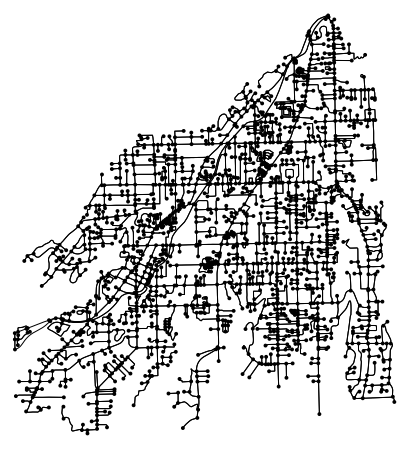

In [37]:
type(map_cons)
ox.plot_graph(map_cons,
             bgcolor='#FFFFFF',
             edge_color='#000000',
             node_color='#000000');

In [32]:
# impute edge (driving) speeds and calculate edge traversal times
map_cons_speed = ox.add_edge_speeds(map_cons)
map_cons_speed = ox.add_edge_travel_times(map_cons_speed)

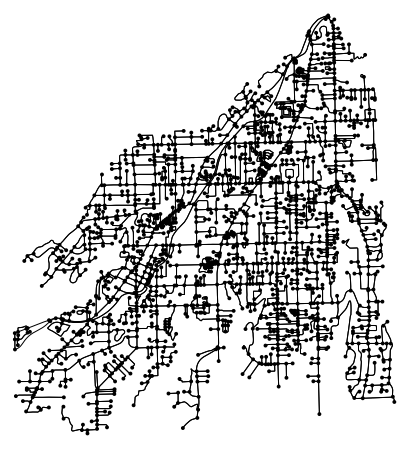

In [40]:
type(map_cons_speed)
ox.plot_graph(map_cons_speed,
             bgcolor='#FFFFFF',
             edge_color='#000000',
             node_color='#000000');

In [42]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(map_cons_speed)
edges_35mph = gdf_edges[gdf_edges["speed_kph"] > 56]
map_cons_speed = ox.graph_from_gdfs(gdf_nodes, edges_35mph, graph_attrs=map_cons_speed.graph)

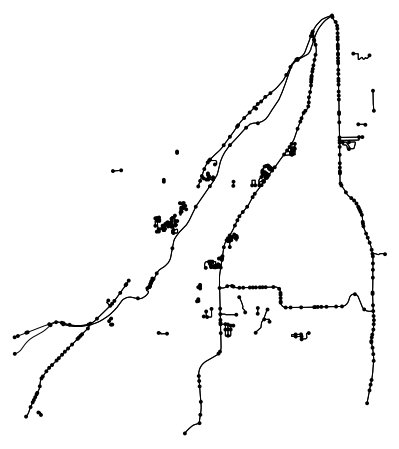

In [43]:
type(map_cons_speed)
ox.plot_graph(map_cons_speed,
             bgcolor='#FFFFFF',
             edge_color='#000000',
             node_color='#000000');

Append connectivity for each name/city with all roads

In [66]:
# Empty list to populate with connectivity
connectivity = []
# For each city in california
for city in t["NAME"]:
    # Attempt to...
    try: 
        # Map
        mapcon = ox.project_graph(ox.graph_from_place(city))
        # Consolidiate nodes
        map_cons = ox.consolidate_intersections(mapcon,
                                                tolerance=10,
                                                rebuild_graph=True,
                                                dead_ends=True)
        # Basic statistics
        basic_stats = ox.basic_stats(map_cons)
        # Append connectivity to list
        connectivity.append([city, basic_stats['streets_per_node_avg'] ])
    # Otherwise        
    except Exception:
        # Pass NaN
        connectivity.append([city, np.nan])

In [67]:
connectivity

[['Cloverdale, California', nan],
 ['Cotati, California', None],
 ['Benicia, California', None],
 ['Dixon, California', None],
 ['Rio Vista, California', None],
 ['Suisun City, California', None],
 ['Rohnert Park, California', None],
 ['Sebastopol, California', None],
 ['Sonoma, California', None],
 ['Los Gatos, California', None],
 ['Gilroy, California', None],
 ['Saratoga, California', None],
 ['Dunsmuir, California', None],
 ['Campbell, California', None],
 ['Cupertino, California', None],
 ['Los Altos Hills, California', None],
 ['Monte Sereno, California', None],
 ['Palo Alto, California', None],
 ['San Jose, California', None],
 ['Marysville, California', None]]

In [62]:
t[['NAMES', 'avg_strt_per_node', 'street_density_km','edge_density_km']] = connectivity

In [63]:
t

NAME              NAMELSAD  Haz_zone  \
0        Cloverdale, California       Cloverdale city         2   
1            Cotati, California           Cotati city         2   
2           Benicia, California          Benicia city         0   
3             Dixon, California            Dixon city         1   
4         Rio Vista, California        Rio Vista city         0   
5       Suisun City, California      Suisun City city         0   
6      Rohnert Park, California     Rohnert Park city         0   
7        Sebastopol, California       Sebastopol city         0   
8            Sonoma, California           Sonoma city         3   
9         Los Gatos, California        Los Gatos town         3   
10           Gilroy, California           Gilroy city         3   
11         Saratoga, California         Saratoga city         3   
12         Dunsmuir, California         Dunsmuir city         3   
13         Campbell, California         Campbell city         1   
14        Cupertino, California        Cupertino city         2   
15  Los Altos Hills, California  Los Altos Hills town         2   
16     Monte Sereno, California     Monte Sereno city         2   
17        Palo Alto, California        Palo Alto city         2   
18         San Jose, California         San Jose city         3   
19       Marysville, California       Marysville city         0   

                                             geometry  \
0   MULTIPOLYGON (((-123.02144 38.81852, -123.0216...   
1   MULTIPOLYGON (((-122.69067 38.31982, -122.6957...   
2   MULTIPOLYGON (((-122.19518 38.06040, -122.1948...   
3   MULTIPOLYGON (((-121.80448 38.39105, -121.8038...   
4   MULTIPOLYGON (((-121.71389 38.19906, -121.7139...   
5   MULTIPOLYGON (((-121.96939 38.25009, -121.9695...   
6   MULTIPOLYGON (((-122.69067 38.31982, -122.6910...   
7   MULTIPOLYGON (((-122.83192 38.38344, -122.8329...   
8   MULTIPOLYGON (((-122.43865 38.28033, -122.4386...   
9   MULTIPOLYGON (((-121.95785 37.22954, -121.9579...   
10  MULTIPOLYGON (((-121.58880 37.04727, -121.5873...   
11  MULTIPOLYGON (((-121.99066 37.26911, -121.9907...   
12  MULTIPOLYGON (((-122.26457 41.25793, -122.2645...   
13  MULTIPOLYGON (((-121.94339 37.27435, -121.9435...   
14  MULTIPOLYGON (((-122.07481 37.33198, -122.0746...   
15  MULTIPOLYGON (((-122.16239 37.39424, -122.1623...   
16  MULTIPOLYGON (((-121.97377 37.25124, -121.9736...   
17  MULTIPOLYGON (((-122.08544 37.45195, -122.0863...   
18  MULTIPOLYGON (((-121.82371 37.20721, -121.8237...   
19  MULTIPOLYGON (((-121.54664 39.17191, -121.5473...   

                          NAMES  avg_strt_per_node  street_density_km  \
0        Cloverdale, California                NaN                NaN   
1            Cotati, California           1.830464                NaN   
2           Benicia, California           1.998499                NaN   
3             Dixon, California           2.323613                NaN   
4         Rio Vista, California           2.435173                NaN   
5       Suisun City, California           1.888889                NaN   
6      Rohnert Park, California           1.778257                NaN   
7        Sebastopol, California           1.900783                NaN   
8            Sonoma, California           1.960606                NaN   
9         Los Gatos, California           1.579566                NaN   
10           Gilroy, California           2.082415                NaN   
11         Saratoga, California           1.982667                NaN   
12         Dunsmuir, California           2.797927                NaN   
13         Campbell, California           1.734381                NaN   
14        Cupertino, California           1.826674                NaN   
15  Los Altos Hills, California           1.723622                NaN   
16     Monte Sereno, California           1.813253                NaN   
17        Palo Alto, California           1.847174                NaN   
18         San Jose, California   

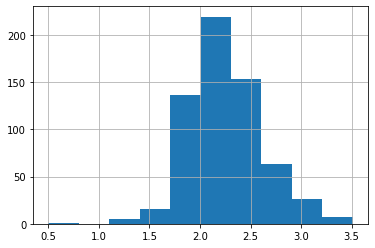

In [100]:
g.avg_strt_per_node.hist();

In [125]:
g.avg_strt_per_node.describe()

count    626.000000
mean       2.255660
std        0.361271
min        0.500000
25%        2.003039
50%        2.217285
75%        2.459861
max        3.511111
Name: avg_strt_per_node, dtype: float64

Conditions [link](https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/)

In [149]:
conditions = [
    g['avg_strt_per_node'].isna(),
    (g['avg_strt_per_node'] <= g.avg_strt_per_node.describe()[4]),
    (g['avg_strt_per_node'] <= g.avg_strt_per_node.describe()[5]) & (g['avg_strt_per_node'] > g.avg_strt_per_node.describe()[4]),
    (g['avg_strt_per_node'] <= g.avg_strt_per_node.describe()[6]) & (g['avg_strt_per_node'] > g.avg_strt_per_node.describe()[5]),
    (g['avg_strt_per_node'] > g.avg_strt_per_node.describe()[6])
    ]

In [150]:
# create a list of the values we want to assign for each condition
values = [np.nan, '1', '2', '3', '4']

In [151]:
# create a new column and use np.select to assign values to it using our lists as arguments
g['connectivity'] = np.select(conditions, values)

summarize

In [152]:
g.connectivity.value_counts()

nan    314
4      157
1      157
3      156
2      156
Name: connectivity, dtype: int64

count number of nans

In [153]:
g.head()

NAME         NAMELSAD  Haz_zone  \
0  Cloverdale, California  Cloverdale city         2   
1      Cotati, California      Cotati city         2   
2     Benicia, California     Benicia city         0   
3       Dixon, California       Dixon city         1   
4   Rio Vista, California   Rio Vista city         0   

                                            geometry  avg_strt_per_node  \
0  MULTIPOLYGON (((-123.02144 38.81852, -123.0216...                NaN   
1  MULTIPOLYGON (((-122.69067 38.31982, -122.6957...           1.830464   
2  MULTIPOLYGON (((-122.19518 38.06040, -122.1948...           1.998499   
3  MULTIPOLYGON (((-121.80448 38.39105, -121.8038...           2.323613   
4  MULTIPOLYGON (((-121.71389 38.19906, -121.7139...           2.435173   

  connectivity Connectivity  
0          nan            0  
1            1            1  
2            1            1  
3            3            3  
4            3            3

- Save as geojson

In [160]:
g.to_file(filename='connectivity.geojson'.format(city), driver='GeoJSON')

In [159]:
os.getcwd()
os.chdir('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_kelper/UnfoldedData/Counties&Cities/')
os.getcwd()

'/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_kelper/UnfoldedData/Counties&Cities'

#### append egress data

import file from Bill

In [16]:
et = pd.read_excel(r'/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/WildfireWatch/UnfoldedData/Polygons/T3_city_sim_summary_210326.xlsx',
                  header=3)

In [17]:
et

Name  Population  Roadway_length_km  Landarea_km2  \
0    Arroyo Grande       17252             242.10          15.1   
1       Atascadero       28310             696.16          66.4   
2        Calistoga        5155              81.11           6.7   
3       El Cerrito       23549             261.42           9.6   
4          Fairfax        7441              83.02           5.7   
5    Half Moon Bay       11324             158.04          16.6   
6         Larkspur       11926              78.93           7.8   
7         Live Oak        8392             105.40           4.8   
8      Mill Valley       13903             199.91          12.3   
9      Nevada City        3068              85.25           5.7   
10          Novato       51904             698.15          71.1   
11          Orinda       17643             409.71          32.8   
12        Pacifica       37234             358.08          32.8   
13        Paradise       26218             623.97          47.4   
14     Placerville       10389             231.32          15.0   
15      Pleasanton       70285             931.76          62.4   
16  Portola Valley        4353             111.10          23.5   
17        Richmond      103701             897.63          77.9   
18            Ross        2415              39.01           4.0   
19     San Anselmo       12336             157.64           6.9   
20       San Bruno       41114             396.47          14.2   
21       San Ramon       72148             824.93          46.8   
22      Santa Cruz       59946            5184.93          33.0   
23      Santa Rosa      167815            1955.44         106.9   
24        Saratoga       29926             521.38          32.1   
25      St. Helena        5814             105.51          12.9   
26      Union City       69516             563.28          50.4   
27    Walnut Creek       64173             666.95          51.2   
28         Willits        4888              95.48           7.3   
29        Woodside        5287             189.89          30.4   
30      Yountville        2933              46.39           4.0   
31         Concord           0               0.00           0.0   
32          Dublin           0               0.00           0.0   
33         Fremont           0               0.00           0.0   
34         Hayward           0               0.00           0.0   
35       Lafayette           0               0.00           0.0   
36       Los Gatos           0               0.00           0.0   
37          Moraga           0               0.00           0.0   
38         Oakland           0               0.00           0.0   
39         Redding           0               0.00           0.0   
40        San Jose           0               0.00           0.0   
41          Gilroy       48821             580.95          41.8   
42        Berkeley      112580             840.67          27.1   
43         Clayton       10897             153.41           9.9   
44    Corte Madera        9253             131.71           8.2   
45        Danville       42039             637.51          46.7   
46   Scotts Valley       11580             188.56          11.9   

    Road_density(km/km2)  Evacuation_time(sec)        Remark  \
0                  16.03                  7364      Complete   
1                  10.48                 13946      Complete   
2                  12.11                  6600      Complete   
3                  27.23                 10128      Complete   
4                  14.57                  8533      Complete   
5                   9.52                  7296      Complete   
6                  10.12                  9023      Complete   
7                  21.96                  7374      Complete   
8                  16.25                  7542      Complete   
9                  14.96                  6664      Complete   
10                  9.82                 27791      Complete   
11                 12.49     

Sanity check

In [19]:
et.shape

(47, 10)

In [21]:
type(et.Name)

pandas.core.series.Series

Add ", California" to each city name

In [22]:
et["Name"] = et["Name"].astype(str) + ", California"

In [26]:
et.head()

Name  Population  Roadway_length_km  Landarea_km2  \
0  Arroyo Grande, California       17252             242.10          15.1   
1     Atascadero, California       28310             696.16          66.4   
2      Calistoga, California        5155              81.11           6.7   
3     El Cerrito, California       23549             261.42           9.6   
4        Fairfax, California        7441              83.02           5.7   

   Road_density(km/km2)  Evacuation_time(sec)    Remark  \
0                 16.03                  7364  Complete   
1                 10.48                 13946  Complete   
2                 12.11                  6600  Complete   
3                 27.23                 10128  Complete   
4                 14.57                  8533  Complete   

                                         dest_taz  \
0                              11432, 11540, 5002   
1                      23931, 22572, 13872, 11694   
2                          152232, 153042, 151626   
3  131199, 124703, 119750, 125595, 116286, 129948   
4                                          143034   

                           edge_id Error_reason  
0                     505, 386, 19          NaN  
1                43, 1256, 731, 15          NaN  
2                    234, -269, 33          NaN  
3  134, -712, 158, 416, 625, -1020          NaN  
4                              291          NaN

Append `et` to `g`

In [33]:
test = g.join(et.set_index('Name'), on='NAME')

In [34]:
test[test["NAME"] == "Arroyo Grande, California"]

NAME            NAMELSAD  Haz_zone  \
127  Arroyo Grande, California  Arroyo Grande city         3   

                                              geometry  Population  \
127  MULTIPOLYGON (((-120.58778 35.10603, -120.5882...     17252.0   

     Roadway_length_km  Landarea_km2  Road_density(km/km2)  \
127              242.1          15.1                 16.03   

     Evacuation_time(sec)    Remark            dest_taz       edge_id  \
127                7364.0  Complete  11432, 11540, 5002  505, 386, 19   

    Error_reason  
127          NaN

Number of 0s

In [47]:
test['Evacuation_time(sec)'].isin([0]).sum()

10

Number of NAs

In [48]:
test['Evacuation_time(sec)'].isna().sum()

892

export data

In [37]:
test.to_file(filename='Egress.geojson', driver='GeoJSON')

In [38]:
os.getcwd()

'/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/WildfireWatch/OSMnx'

### Convert xy coordinates at timestamps to linestring in geojson

import  

In [2]:
# import shapefile using geopandas
tf = pd.read_csv('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_est/Trials/PG&ECities/fcd_out_1.csv')

In [3]:
tf.head()

timestep   id           x          y  speed
0         1   63 -121.579609  39.777788  14.21
1         2   63 -121.579761  39.777789  13.00
2         3  283 -121.600506  39.777636  12.58
3         3   63 -121.579916  39.777790  13.30
4         4  283 -121.600366  39.777636  11.98

In [4]:
tf.shape

(2669373, 5)

In [5]:
tf.dtypes

timestep      int64
id            int64
x           float64
y           float64
speed       float64
dtype: object

- Is timestep just a list of sequential integers

In [6]:
sorted(tf['timestep']) == list(range(min(tf['timestep']), max(tf['timestep'])+1))

False

- convert timestep to integer

In [7]:
tf['timestep'] = tf['timestep'].astype(np.int64)

- convert timestep to unix in seconds

In [8]:
tf['timestep'] = 1609520400 + tf['timestep']

In [9]:
tf[['x','y','speed','timestep']]

x          y  speed    timestep
0       -121.579609  39.777788  14.21  1609520401
1       -121.579761  39.777789  13.00  1609520402
2       -121.600506  39.777636  12.58  1609520403
3       -121.579916  39.777790  13.30  1609520403
4       -121.600366  39.777636  11.98  1609520404
...             ...        ...    ...         ...
2669368 -121.583458  39.799539   3.54  1609524300
2669369 -121.608164  39.776099   0.06  1609524300
2669370 -121.604850  39.779135   4.78  1609524300
2669371 -121.604832  39.779103   0.14  1609524300
2669372 -121.600622  39.783057   0.82  1609524300

[2669373 rows x 4 columns]

In [10]:
tf.shape

(2669373, 5)

- Subset data to optimize data storage

In [11]:
# # tfs1 = tf[tf['id']==1]
# # tfs2 = tf[tf['id']==2]
# tf5 = tf[tf['id'] < 5]

- reorder columns as directed by [unfolded](https://docs.unfolded.ai/studio/layer-reference/trip)

In [679]:
# tfs1, tfs2 = tfs1[['x','y','speed',"timestep"]], tfs2[['x','y','speed',"timestep"]]
# tf = tf[['x','y','speed',"timestep"]]

In [655]:
# tfs1

x          y  speed    timestep
75000  -121.582047  39.777766  15.10  1609520893
207492 -121.623742  39.770460  12.37  1609521250
119475 -121.600513  39.777665  11.40  1609521026
81566  -121.585602  39.777743  13.98  1609520914
118070 -121.599964  39.777664  10.31  1609521022
...            ...        ...    ...         ...
240149 -121.633506  39.770484   3.85  1609521327
166953 -121.611992  39.771107   0.36  1609521152
103888 -121.594605  39.777732  11.06  1609520981
186408 -121.616933  39.770378  13.03  1609521199
140200 -121.606203  39.777660   4.91  1609521083

[461 rows x 4 columns]

- convert to list

In [680]:
# Aggregate these points with the GroupBy
# tfsl1,tfsl2 = tfs1[['x','y','speed','timestep']].values.tolist(), tfs2[['x','y','speed','timestep']].values.tolist()

- populate geojson

In [13]:
# l = {
#   "type": "FeatureCollection",
#   "features": [
#     {
#       "type": "Feature",
#       "properties": {
#         "vehicle": "0"
#       },
#       "geometry": {
#         "type": "LineString",
#         "coordinates": tfsl[0:]
#       }
#     }
#   ]
# }

- 2

In [681]:
l = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "vendor": "A"
      },
      "geometry": {
        "type": "LineString",
        "coordinates": tfsl1[0:]
      }
    },
      
      {
      "type": "Feature",
      "properties": {
        "vendor": "B"
      },
      "geometry": {
        "type": "LineString",
        "coordinates": tfsl2[0:]
      }
    }
  ]
}

In [3]:
# gpd.read_file('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_kelper/MicroSimulations/sumo_fcdout_keplerjson.geojson')

In [ ]:
# import json
# with open('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_est/Trials/PG&ECities/v12.geojson', 'w') as fp:
#     json.dump(t, fp)

- Generalize to for loop

In [12]:
# Empty dict to populate
F = []
# for each vehicle id
for v in tf['id'].unique():
    # convert each row to list
    f = {
      "type": "Feature",
      "properties": {
        "vehicle": v
      },
      "geometry": {
        "type": "LineString",
        "coordinates": 
          tf[['x','y','speed','timestep']].loc[tf['id'] == v].values.tolist()
          }
        }
    # Append to list
    F.append(f)

- insert back into json

In [14]:
r = {
  "type": "FeatureCollection",
  "features": F
    }

In [15]:
import json
import numpy as np


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

# # Your codes .... 


# print(json_object[:500])

In [6]:
t.to_file('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_kelper/MicroSimulations/test.geojson', driver='GeoJSON')

In [14]:
with open('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/egress_kelper/MicroSimulations/test.geojson', 'r') as handle:
    parsed = json.load(handle)

In [17]:
# parsed

In [2]:
# r

In [599]:
# Empty dict to populate
F = []
# for each vehicle id
for v in df['id'].unique():
    # convert each row to list
    f = {
      "type": "Feature",
      "properties": {
        "vehicle": v
      },
      "geometry": {
        "type": "LineString",
        "coordinates": 
          df[['x','y','speed','timestep']].loc[df['id'] == v].values.tolist()
          }
        }
    # Append to list
    F.append(f)

In [600]:
r = {
  "type": "FeatureCollection",
  "features": F
    }

In [601]:
r

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'vehicle': 0},
   'geometry': {'type': 'LineString',
    'coordinates': [[-121.595231, 39.777735, 9.14, 1609523012.0],
     [-121.589025, 39.77773, 12.48, 1609522955.0],
     [-121.618616, 39.770395, 12.55, 1609523303.0],
     [-121.597321, 39.777709, 8.17, 1609523033.0]]}},
  {'type': 'Feature',
   'properties': {'vehicle': 1},
   'geometry': {'type': 'LineString',
    'coordinates': [[-121.60572, 39.777672, 0.0, 1609523143.0],
     [-121.611122, 39.77296, 14.62, 1609523238.0],
     [-121.584446, 39.777757, 12.19, 1609522923.0],
     [-121.60572, 39.777672, 0.0, 1609523163.0]]}},
  {'type': 'Feature',
   'properties': {'vehicle': 2},
   'geometry': {'type': 'LineString',
    'coordinates': [[-121.60572, 39.777672, 0.0, 1609523164.0],
     [-121.582437, 39.777761, 11.99, 1609522909.0],
     [-121.624386, 39.770472, 13.19, 1609523342.0],
     [-121.592178, 39.777724, 8.84, 1609522981.0]]}}]}

In [169]:
a

NAME             NAMELSAD  Haz_zone  \
0         Cloverdale, California      Cloverdale city         2   
1             Cotati, California          Cotati city         2   
2            Benicia, California         Benicia city         0   
3              Dixon, California           Dixon city         1   
4          Rio Vista, California       Rio Vista city         0   
..                           ...                  ...       ...   
935           Yettem, California           Yettem CDP         0   
936             Yolo, California             Yolo CDP         0   
937   Yosemite Lakes, California   Yosemite Lakes CDP         2   
938  Yosemite Valley, California  Yosemite Valley CDP         2   
939          Zayante, California          Zayante CDP         3   

                                              geometry  
0    MULTIPOLYGON (((-123.02144 38.81852, -123.0216...  
1    MULTIPOLYGON (((-122.69067 38.31982, -122.6957...  
2    MULTIPOLYGON (((-122.19518 38.06040, -122.1948...  
3    MULTIPOLYGON (((-121.80448 38.39105, -121.8038...  
4    MULTIPOLYGON (((-121.71389 38.19906, -121.7139...  
..                                                 ...  
935  MULTIPOLYGON (((-119.24955 36.48676, -119.2495...  
936  MULTIPOLYGON (((-121.81530 38.75000, -121.8138...  
937  MULTIPOLYGON (((-119.77305 37.23475, -119.7729...  
938  MULTIPOLYGON (((-119.57291 37.74729, -119.5728...  
939  MULTIPOLYGON (((-122.05079 37.05517, -122.0520...  

[940 rows x 4 columns]

In [2]:
with open('/Users/davidlinnardwheeler/Desktop/Desktop - David’s MacBook Pro/DataScience/BERKELEY/W210/WildfireWatch/UnfoldedData/Trips/fcd_AllVehicles_filtered.geojson', 'r') as handle:
    parsed = json.load(handle)

In [3]:
parsed

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'vehicle': 63},
   'geometry': {'type': 'LineString',
    'coordinates': [[-121.579609, 39.777788, 14.21, 1609520401.0],
     [-121.581177, 39.777786, 14.04, 1609520411.0],
     [-121.58277, 39.777762, 13.64, 1609520421.0],
     [-121.584358, 39.777759, 13.91, 1609520431.0],
     [-121.58595, 39.777743, 13.14, 1609520441.0],
     [-121.587534, 39.777746, 14.05, 1609520451.0],
     [-121.589101, 39.777729, 14.14, 1609520461.0],
     [-121.590697, 39.77772, 14.2, 1609520471.0],
     [-121.592286, 39.777726, 13.15, 1609520481.0],
     [-121.593871, 39.777725, 14.01, 1609520491.0],
     [-121.595477, 39.77773, 13.15, 1609520501.0],
     [-121.597085, 39.777708, 13.14, 1609520511.0],
     [-121.598678, 39.777677, 13.44, 1609520521.0],
     [-121.600261, 39.777665, 13.96, 1609520531.0],
     [-121.601852, 39.777665, 13.0, 1609520541.0],
     [-121.603443, 39.777677, 13.76, 1609520551.0],
     [-121.605001, 39.7

In [3]:
parsed

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'vehId': '1016'},
   'geometry': {'type': 'LineString',
    'coordinates': [[-122.288249, 37.885991, 0, 60.0],
     [-122.292605, 37.884722, 0, 120.0],
     [-122.296777, 37.883882, 0, 180.0]]}},
  {'type': 'Feature',
   'properties': {'vehId': '1026'},
   'geometry': {'type': 'LineString',
    'coordinates': [[-122.29078, 37.89061, 0, 60.0],
     [-122.294602, 37.887362, 0, 120.0]]}},
  {'type': 'Feature',
   'properties': {'vehId': '1063'},
   'geometry': {'type': 'LineString',
    'coordinates': [[-122.295311, 37.884177, 0, 60.0]]}},
  {'type': 'Feature',
   'properties': {'vehId': '1086'},
   'geometry': {'type': 'LineString',
    'coordinates': [[-122.29008, 37.885153, 0, 60.0],
     [-122.296434, 37.883952, 0, 120.0]]}},
  {'type': 'Feature',
   'properties': {'vehId': '11'},
   'geometry': {'type': 'LineString',
    'coordinates': [[-122.298369, 37.888632, 0, 60.0],
     [-122.298238, 37.887892, 0,